# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
import os

In [4]:
current_path = "/content/drive/MyDrive/ERA-V1/era_v1_session9_pankaja"
current_path

'/content/drive/MyDrive/ERA-V1/era_v1_session9_pankaja'

In [5]:
os.chdir(current_path)
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1tfbtPBYDWavr0w-8E9VcOHtGbw2lVRzY/era_v1_session9_pankaja'

In [9]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torchsummary

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-u26s0_sp
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-u26s0_sp
  Resolved https://github.com/albumentations-team/albumentations.git to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=bc7a5da135f5704f7a4a23c4b02236a8e217cf9957efd70ccd7306c289e3104a
  Stored in directory: /tmp/pip-ephem-wheel-cache-xigmaber/wheels/f9/34/b6/eb7adf92e69b5629d7de6904c0d4ac4e5050b18ce065bab4e1
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [6]:
from __future__ import print_function
import numpy as np
from utils import plot_metrics, train, test, helper
from models import model, model_fc
import torch
import torch.nn as nn
from pprint import pprint

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

import torchvision
from torchsummary import summary
from dataloader.load_data import Cifar10DataLoader
from utils.engine import TriggerEngine


## Load config file

In [7]:
config = helper.process_config("./config/config.yaml")
use_cuda = torch.cuda.is_available()
helper.set_seed(config['model_params']['seed'],use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

pprint(config)

 loading Configuration of your experiment ..
{'criterion': 'CrossEntropyLoss',
 'data_augmentation': {'args': {'cutout_prob': 0.5,
                                'horizontalflip_prob': 0.2,
                                'num_holes': 1,
                                'rotate_limit': 15,
                                'shiftscalerotate_prob': 0.25},
                       'type': 'albumentation'},
 'data_loader': {'args': {'batch_size': 256,
                          'num_workers': 2,
                          'pin_memory': True},
                 'classes': ['plane',
                             'car',
                             'bird',
                             'cat',
                             'deer',
                             'dog',
                             'frog',
                             'horse',
                             'ship',
                             'truck'],
                 'type': 'CIFAR10DataLoader'},
 'model': 'cifar10',
 'model_params': {'dr

In [ ]:
# save_model_dir = config['model_params']['save_model_dir']
# print(save_model_dir)
# if not os.path.exists(save_model_dir):
#     os.mkdir(save_model_dir, mode = 0o777)

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [8]:
model = model.Net(0.01).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         Dropout2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,080
             ReLU-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
             ReLU-12           [-1, 32, 32, 32]               0
      BatchNorm2d-13           [-1, 32, 32, 32]              64
        Dropout2d-14           [-1, 32,

In [9]:
# FC layer - to be TESTED
model_2 = model_fc.Net2(0.01).to(device)
summary(model_2, input_size=(3, 32, 32))

x: torch.Size([2, 10, 1, 1])
x: torch.Size([2, 10])
x: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         Dropout2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,080
             ReLU-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
             ReLU-12           [-1, 32, 32, 32]               0
      BatchNorm2d-13        

## Download data and view sample images

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


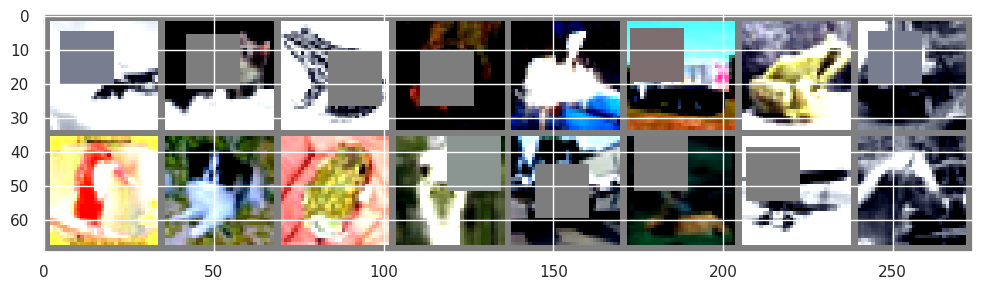

In [14]:
# functions to show an image
cifar_dataset = Cifar10DataLoader(config)
classes= config['data_loader']['classes']
fig, ax = plt.subplots(figsize=(12, 12))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


try:
  # get some random training images
  dataiter = iter(cifar_dataset.train_loader)
  images, labels = next(dataiter)

  # show images
  imshow(torchvision.utils.make_grid(images[:16]))
except Exception as ex:
  print(f"Error occurred: {ex}")


## Trigger training

**model_gap: incorporates last layer as GAP before softmax**

In [9]:
exp_metrics_gap={}
config['model_params']['experiment_name'] = 'CiFar_Model_GAP'
experiment_name_gap = config['model_params']['experiment_name']

config['model_params']['model_for'] = 'gap'
config['model_params']['model_name'] = 'CiFar_Model_GAP'
config['model_params']['save_model'] = 'Y'

trigger_training_gap = TriggerEngine(config)

# trigger_training.
(exp_metrics_gap[experiment_name_gap]), model_gap = trigger_training_gap.run_experiment()
trigger_training_gap.save_experiment(model_gap, experiment_name_gap)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Running experiment with 'CiFar_Model_GAP' model...
Epoch 1:


Loss=1.797356367111206 Batch_id=195 LR=0.00043 Accuracy=30.96: 100%|██████████| 196/196 [00:22<00:00,  8.81it/s]



Test set: Average loss: 0.0066, Accuracy: 4636/10000 (46.36%)

Epoch 2:


Loss=1.6634528636932373 Batch_id=195 LR=0.00053 Accuracy=43.56: 100%|██████████| 196/196 [00:19<00:00, 10.05it/s]



Test set: Average loss: 0.0058, Accuracy: 5411/10000 (54.11%)

Epoch 3:


Loss=1.4987847805023193 Batch_id=195 LR=0.00069 Accuracy=49.94: 100%|██████████| 196/196 [00:21<00:00,  8.96it/s]



Test set: Average loss: 0.0050, Accuracy: 6046/10000 (60.46%)

Epoch 4:


Loss=1.368944525718689 Batch_id=195 LR=0.00091 Accuracy=55.22: 100%|██████████| 196/196 [00:19<00:00,  9.91it/s]



Test set: Average loss: 0.0048, Accuracy: 6136/10000 (61.36%)

Epoch 5:


Loss=1.2792810201644897 Batch_id=195 LR=0.00119 Accuracy=57.98: 100%|██████████| 196/196 [00:21<00:00,  9.15it/s]



Test set: Average loss: 0.0046, Accuracy: 6346/10000 (63.46%)

Epoch 6:


Loss=1.0562185049057007 Batch_id=195 LR=0.00152 Accuracy=60.88: 100%|██████████| 196/196 [00:19<00:00,  9.92it/s]



Test set: Average loss: 0.0041, Accuracy: 6762/10000 (67.62%)

Epoch 7:


Loss=1.0379629135131836 Batch_id=195 LR=0.00191 Accuracy=63.55: 100%|██████████| 196/196 [00:22<00:00,  8.83it/s]



Test set: Average loss: 0.0036, Accuracy: 7088/10000 (70.88%)

Epoch 8:


Loss=0.9957456588745117 Batch_id=195 LR=0.00233 Accuracy=65.45: 100%|██████████| 196/196 [00:19<00:00,  9.83it/s]



Test set: Average loss: 0.0035, Accuracy: 7141/10000 (71.41%)

Epoch 9:


Loss=0.840774416923523 Batch_id=195 LR=0.00280 Accuracy=66.22: 100%|██████████| 196/196 [00:21<00:00,  9.02it/s]



Test set: Average loss: 0.0032, Accuracy: 7347/10000 (73.47%)

Epoch 10:


Loss=0.9790708422660828 Batch_id=195 LR=0.00330 Accuracy=67.52: 100%|██████████| 196/196 [00:20<00:00,  9.79it/s]



Test set: Average loss: 0.0031, Accuracy: 7334/10000 (73.34%)

Epoch 11:


Loss=0.9149578213691711 Batch_id=195 LR=0.00382 Accuracy=68.49: 100%|██████████| 196/196 [00:21<00:00,  8.96it/s]



Test set: Average loss: 0.0037, Accuracy: 6941/10000 (69.41%)

Epoch 12:


Loss=0.9055137634277344 Batch_id=195 LR=0.00437 Accuracy=69.21: 100%|██████████| 196/196 [00:20<00:00,  9.70it/s]



Test set: Average loss: 0.0033, Accuracy: 7255/10000 (72.55%)

Epoch 13:


Loss=0.8652180433273315 Batch_id=195 LR=0.00492 Accuracy=69.74: 100%|██████████| 196/196 [00:21<00:00,  9.05it/s]



Test set: Average loss: 0.0033, Accuracy: 7239/10000 (72.39%)

Epoch 14:


Loss=0.9718872308731079 Batch_id=195 LR=0.00548 Accuracy=70.18: 100%|██████████| 196/196 [00:20<00:00,  9.58it/s]



Test set: Average loss: 0.0029, Accuracy: 7483/10000 (74.83%)

Epoch 15:


Loss=0.8778572082519531 Batch_id=195 LR=0.00604 Accuracy=70.50: 100%|██████████| 196/196 [00:20<00:00,  9.36it/s]



Test set: Average loss: 0.0029, Accuracy: 7546/10000 (75.46%)

Epoch 16:


Loss=1.0114080905914307 Batch_id=195 LR=0.00658 Accuracy=70.56: 100%|██████████| 196/196 [00:21<00:00,  9.19it/s]



Test set: Average loss: 0.0028, Accuracy: 7671/10000 (76.71%)

Epoch 17:


Loss=0.7411366701126099 Batch_id=195 LR=0.00710 Accuracy=71.05: 100%|██████████| 196/196 [00:20<00:00,  9.58it/s]



Test set: Average loss: 0.0028, Accuracy: 7605/10000 (76.05%)

Epoch 18:


Loss=0.9314680099487305 Batch_id=195 LR=0.00760 Accuracy=71.29: 100%|██████████| 196/196 [00:22<00:00,  8.85it/s]



Test set: Average loss: 0.0026, Accuracy: 7748/10000 (77.48%)

Epoch 19:


Loss=0.8770290613174438 Batch_id=195 LR=0.00807 Accuracy=71.60: 100%|██████████| 196/196 [00:21<00:00,  9.28it/s]



Test set: Average loss: 0.0033, Accuracy: 7265/10000 (72.65%)

Epoch 20:


Loss=0.7784581780433655 Batch_id=195 LR=0.00850 Accuracy=71.52: 100%|██████████| 196/196 [00:22<00:00,  8.54it/s]



Test set: Average loss: 0.0031, Accuracy: 7386/10000 (73.86%)

Epoch 21:


Loss=0.8017187118530273 Batch_id=195 LR=0.00888 Accuracy=71.98: 100%|██████████| 196/196 [00:20<00:00,  9.51it/s]



Test set: Average loss: 0.0025, Accuracy: 7878/10000 (78.78%)

Epoch 22:


Loss=0.8942998647689819 Batch_id=195 LR=0.00921 Accuracy=71.96: 100%|██████████| 196/196 [00:21<00:00,  9.01it/s]



Test set: Average loss: 0.0029, Accuracy: 7552/10000 (75.52%)

Epoch 23:


Loss=0.9009509086608887 Batch_id=195 LR=0.00949 Accuracy=72.18: 100%|██████████| 196/196 [00:21<00:00,  9.22it/s]



Test set: Average loss: 0.0035, Accuracy: 7221/10000 (72.21%)

Epoch 24:


Loss=0.596554160118103 Batch_id=195 LR=0.00971 Accuracy=72.29: 100%|██████████| 196/196 [00:20<00:00,  9.52it/s]



Test set: Average loss: 0.0027, Accuracy: 7767/10000 (77.67%)

Epoch 25:


Loss=0.7202917337417603 Batch_id=195 LR=0.00987 Accuracy=72.49: 100%|██████████| 196/196 [00:22<00:00,  8.66it/s]



Test set: Average loss: 0.0029, Accuracy: 7558/10000 (75.58%)

Epoch 26:


Loss=0.9747052192687988 Batch_id=195 LR=0.00997 Accuracy=72.75: 100%|██████████| 196/196 [00:20<00:00,  9.47it/s]



Test set: Average loss: 0.0028, Accuracy: 7586/10000 (75.86%)

Epoch 27:


Loss=0.7595087885856628 Batch_id=195 LR=0.01000 Accuracy=72.90: 100%|██████████| 196/196 [00:22<00:00,  8.70it/s]



Test set: Average loss: 0.0026, Accuracy: 7770/10000 (77.70%)

Epoch 28:


Loss=0.9501803517341614 Batch_id=195 LR=0.00999 Accuracy=73.03: 100%|██████████| 196/196 [00:20<00:00,  9.42it/s]



Test set: Average loss: 0.0028, Accuracy: 7644/10000 (76.44%)

Epoch 29:


Loss=0.7316248416900635 Batch_id=195 LR=0.00998 Accuracy=73.35: 100%|██████████| 196/196 [00:21<00:00,  9.01it/s]



Test set: Average loss: 0.0031, Accuracy: 7380/10000 (73.80%)

Epoch 30:


Loss=0.7537771463394165 Batch_id=195 LR=0.00994 Accuracy=73.31: 100%|██████████| 196/196 [00:21<00:00,  9.26it/s]



Test set: Average loss: 0.0027, Accuracy: 7691/10000 (76.91%)

Epoch 31:


Loss=0.6480299234390259 Batch_id=195 LR=0.00990 Accuracy=73.13: 100%|██████████| 196/196 [00:20<00:00,  9.41it/s]



Test set: Average loss: 0.0027, Accuracy: 7704/10000 (77.04%)

Epoch 32:


Loss=0.6454513072967529 Batch_id=195 LR=0.00985 Accuracy=73.61: 100%|██████████| 196/196 [00:22<00:00,  8.90it/s]



Test set: Average loss: 0.0029, Accuracy: 7487/10000 (74.87%)

Epoch 33:


Loss=0.6812914609909058 Batch_id=195 LR=0.00978 Accuracy=73.36: 100%|██████████| 196/196 [00:20<00:00,  9.45it/s]



Test set: Average loss: 0.0032, Accuracy: 7304/10000 (73.04%)

Epoch 34:


Loss=0.7269635796546936 Batch_id=195 LR=0.00970 Accuracy=73.24: 100%|██████████| 196/196 [00:22<00:00,  8.67it/s]



Test set: Average loss: 0.0025, Accuracy: 7921/10000 (79.21%)

Epoch 35:


Loss=0.595183253288269 Batch_id=195 LR=0.00961 Accuracy=73.73: 100%|██████████| 196/196 [00:20<00:00,  9.43it/s]



Test set: Average loss: 0.0027, Accuracy: 7723/10000 (77.23%)

Epoch 36:


Loss=0.9275287389755249 Batch_id=195 LR=0.00950 Accuracy=73.86: 100%|██████████| 196/196 [00:22<00:00,  8.76it/s]



Test set: Average loss: 0.0028, Accuracy: 7641/10000 (76.41%)

Epoch 37:


Loss=0.5307304263114929 Batch_id=195 LR=0.00939 Accuracy=73.89: 100%|██████████| 196/196 [00:20<00:00,  9.40it/s]



Test set: Average loss: 0.0025, Accuracy: 7836/10000 (78.36%)

Epoch 38:


Loss=0.6967288255691528 Batch_id=195 LR=0.00927 Accuracy=73.75: 100%|██████████| 196/196 [00:21<00:00,  9.10it/s]



Test set: Average loss: 0.0030, Accuracy: 7526/10000 (75.26%)

Epoch 39:


Loss=0.8103612661361694 Batch_id=195 LR=0.00913 Accuracy=74.11: 100%|██████████| 196/196 [00:20<00:00,  9.39it/s]



Test set: Average loss: 0.0030, Accuracy: 7478/10000 (74.78%)

Epoch 40:


Loss=0.7242313027381897 Batch_id=195 LR=0.00898 Accuracy=74.23: 100%|██████████| 196/196 [00:20<00:00,  9.43it/s]



Test set: Average loss: 0.0027, Accuracy: 7751/10000 (77.51%)

Epoch 41:


Loss=0.8908074498176575 Batch_id=195 LR=0.00883 Accuracy=74.30: 100%|██████████| 196/196 [00:22<00:00,  8.87it/s]



Test set: Average loss: 0.0024, Accuracy: 7935/10000 (79.35%)

Epoch 42:


Loss=0.9368106722831726 Batch_id=195 LR=0.00866 Accuracy=74.34: 100%|██████████| 196/196 [00:20<00:00,  9.48it/s]



Test set: Average loss: 0.0024, Accuracy: 7930/10000 (79.30%)

Epoch 43:


Loss=0.7660528421401978 Batch_id=195 LR=0.00849 Accuracy=74.58: 100%|██████████| 196/196 [00:22<00:00,  8.82it/s]



Test set: Average loss: 0.0030, Accuracy: 7519/10000 (75.19%)

Epoch 44:


Loss=0.9065315127372742 Batch_id=195 LR=0.00831 Accuracy=74.97: 100%|██████████| 196/196 [00:20<00:00,  9.65it/s]



Test set: Average loss: 0.0026, Accuracy: 7875/10000 (78.75%)

Epoch 45:


Loss=0.7688732147216797 Batch_id=195 LR=0.00812 Accuracy=74.96: 100%|██████████| 196/196 [00:22<00:00,  8.73it/s]



Test set: Average loss: 0.0028, Accuracy: 7663/10000 (76.63%)

Epoch 46:


Loss=0.7276902794837952 Batch_id=195 LR=0.00792 Accuracy=74.76: 100%|██████████| 196/196 [00:20<00:00,  9.60it/s]



Test set: Average loss: 0.0025, Accuracy: 7992/10000 (79.92%)

Epoch 47:


Loss=0.8174808621406555 Batch_id=195 LR=0.00771 Accuracy=75.19: 100%|██████████| 196/196 [00:21<00:00,  9.19it/s]



Test set: Average loss: 0.0022, Accuracy: 8148/10000 (81.48%)

Epoch 48:


Loss=0.8035149574279785 Batch_id=195 LR=0.00750 Accuracy=75.79: 100%|██████████| 196/196 [00:20<00:00,  9.74it/s]



Test set: Average loss: 0.0024, Accuracy: 8003/10000 (80.03%)

Epoch 49:


Loss=0.6398104429244995 Batch_id=195 LR=0.00728 Accuracy=75.68: 100%|██████████| 196/196 [00:21<00:00,  9.29it/s]



Test set: Average loss: 0.0021, Accuracy: 8174/10000 (81.74%)

Epoch 50:


Loss=0.8655187487602234 Batch_id=195 LR=0.00706 Accuracy=75.91: 100%|██████████| 196/196 [00:21<00:00,  8.91it/s]



Test set: Average loss: 0.0023, Accuracy: 8112/10000 (81.12%)

Epoch 51:


Loss=0.8216463327407837 Batch_id=195 LR=0.00683 Accuracy=76.24: 100%|██████████| 196/196 [00:20<00:00,  9.64it/s]



Test set: Average loss: 0.0022, Accuracy: 8116/10000 (81.16%)

Epoch 52:


Loss=0.6514502167701721 Batch_id=195 LR=0.00659 Accuracy=76.24: 100%|██████████| 196/196 [00:22<00:00,  8.82it/s]



Test set: Average loss: 0.0027, Accuracy: 7782/10000 (77.82%)

Epoch 53:


Loss=0.8671647906303406 Batch_id=195 LR=0.00635 Accuracy=76.62: 100%|██████████| 196/196 [00:20<00:00,  9.72it/s]



Test set: Average loss: 0.0026, Accuracy: 7862/10000 (78.62%)

Epoch 54:


Loss=0.8652805089950562 Batch_id=195 LR=0.00611 Accuracy=76.68: 100%|██████████| 196/196 [00:22<00:00,  8.85it/s]



Test set: Average loss: 0.0024, Accuracy: 7895/10000 (78.95%)

Epoch 55:


Loss=0.6495329141616821 Batch_id=195 LR=0.00587 Accuracy=76.94: 100%|██████████| 196/196 [00:20<00:00,  9.65it/s]



Test set: Average loss: 0.0020, Accuracy: 8263/10000 (82.63%)

Epoch 56:


Loss=0.6981748342514038 Batch_id=195 LR=0.00562 Accuracy=77.17: 100%|██████████| 196/196 [00:20<00:00,  9.38it/s]



Test set: Average loss: 0.0022, Accuracy: 8133/10000 (81.33%)

Epoch 57:


Loss=0.6094674468040466 Batch_id=195 LR=0.00537 Accuracy=77.47: 100%|██████████| 196/196 [00:20<00:00,  9.67it/s]



Test set: Average loss: 0.0020, Accuracy: 8330/10000 (83.30%)

Epoch 58:


Loss=0.7504197359085083 Batch_id=195 LR=0.00512 Accuracy=77.75: 100%|██████████| 196/196 [00:20<00:00,  9.57it/s]



Test set: Average loss: 0.0020, Accuracy: 8317/10000 (83.17%)

Epoch 59:


Loss=0.7831207513809204 Batch_id=195 LR=0.00487 Accuracy=78.06: 100%|██████████| 196/196 [00:20<00:00,  9.36it/s]



Test set: Average loss: 0.0020, Accuracy: 8344/10000 (83.44%)

Epoch 60:


Loss=0.6422945857048035 Batch_id=195 LR=0.00463 Accuracy=78.11: 100%|██████████| 196/196 [00:20<00:00,  9.75it/s]



Test set: Average loss: 0.0020, Accuracy: 8343/10000 (83.43%)

Epoch 61:


Loss=0.6753563284873962 Batch_id=195 LR=0.00438 Accuracy=78.82: 100%|██████████| 196/196 [00:22<00:00,  8.89it/s]



Test set: Average loss: 0.0018, Accuracy: 8504/10000 (85.04%)

Epoch 62:


Loss=0.6387374401092529 Batch_id=195 LR=0.00413 Accuracy=78.45: 100%|██████████| 196/196 [00:20<00:00,  9.63it/s]



Test set: Average loss: 0.0019, Accuracy: 8375/10000 (83.75%)

Epoch 63:


Loss=0.6368915438652039 Batch_id=195 LR=0.00389 Accuracy=79.07: 100%|██████████| 196/196 [00:22<00:00,  8.85it/s]



Test set: Average loss: 0.0019, Accuracy: 8438/10000 (84.38%)

Epoch 64:


Loss=0.6813734769821167 Batch_id=195 LR=0.00364 Accuracy=79.63: 100%|██████████| 196/196 [00:20<00:00,  9.68it/s]



Test set: Average loss: 0.0018, Accuracy: 8450/10000 (84.50%)

Epoch 65:


Loss=0.5898445844650269 Batch_id=195 LR=0.00341 Accuracy=79.49: 100%|██████████| 196/196 [00:21<00:00,  9.13it/s]



Test set: Average loss: 0.0018, Accuracy: 8484/10000 (84.84%)

Epoch 66:


Loss=0.5533381700515747 Batch_id=195 LR=0.00317 Accuracy=80.13: 100%|██████████| 196/196 [00:20<00:00,  9.68it/s]



Test set: Average loss: 0.0017, Accuracy: 8546/10000 (85.46%)

Epoch 67:


Loss=0.48694777488708496 Batch_id=195 LR=0.00294 Accuracy=80.29: 100%|██████████| 196/196 [00:20<00:00,  9.56it/s]



Test set: Average loss: 0.0018, Accuracy: 8534/10000 (85.34%)

Epoch 68:


Loss=0.5987123250961304 Batch_id=195 LR=0.00272 Accuracy=80.73: 100%|██████████| 196/196 [00:20<00:00,  9.51it/s]



Test set: Average loss: 0.0017, Accuracy: 8573/10000 (85.73%)

Epoch 69:


Loss=0.4764460623264313 Batch_id=195 LR=0.00250 Accuracy=80.91: 100%|██████████| 196/196 [00:20<00:00,  9.75it/s]



Test set: Average loss: 0.0018, Accuracy: 8518/10000 (85.18%)

Epoch 70:


Loss=0.545475423336029 Batch_id=195 LR=0.00229 Accuracy=81.20: 100%|██████████| 196/196 [00:21<00:00,  9.10it/s]



Test set: Average loss: 0.0016, Accuracy: 8583/10000 (85.83%)

Epoch 71:


Loss=0.44377416372299194 Batch_id=195 LR=0.00208 Accuracy=81.29: 100%|██████████| 196/196 [00:20<00:00,  9.59it/s]



Test set: Average loss: 0.0016, Accuracy: 8621/10000 (86.21%)

Epoch 72:


Loss=0.39362281560897827 Batch_id=195 LR=0.00188 Accuracy=81.55: 100%|██████████| 196/196 [00:22<00:00,  8.91it/s]



Test set: Average loss: 0.0016, Accuracy: 8646/10000 (86.46%)

Epoch 73:


Loss=0.6779860258102417 Batch_id=195 LR=0.00169 Accuracy=82.26: 100%|██████████| 196/196 [00:20<00:00,  9.64it/s]



Test set: Average loss: 0.0016, Accuracy: 8686/10000 (86.86%)

Epoch 74:


Loss=0.48649391531944275 Batch_id=195 LR=0.00151 Accuracy=82.36: 100%|██████████| 196/196 [00:22<00:00,  8.87it/s]



Test set: Average loss: 0.0015, Accuracy: 8668/10000 (86.68%)

Epoch 75:


Loss=0.36163803935050964 Batch_id=195 LR=0.00133 Accuracy=82.63: 100%|██████████| 196/196 [00:20<00:00,  9.66it/s]



Test set: Average loss: 0.0015, Accuracy: 8713/10000 (87.13%)

Epoch 76:


Loss=0.8288514018058777 Batch_id=195 LR=0.00117 Accuracy=83.01: 100%|██████████| 196/196 [00:21<00:00,  8.99it/s]



Test set: Average loss: 0.0014, Accuracy: 8729/10000 (87.29%)

Epoch 77:


Loss=0.43559765815734863 Batch_id=195 LR=0.00101 Accuracy=83.26: 100%|██████████| 196/196 [00:20<00:00,  9.71it/s]



Test set: Average loss: 0.0015, Accuracy: 8743/10000 (87.43%)

Epoch 78:


Loss=0.3582945466041565 Batch_id=195 LR=0.00087 Accuracy=83.55: 100%|██████████| 196/196 [00:21<00:00,  8.92it/s]



Test set: Average loss: 0.0014, Accuracy: 8796/10000 (87.96%)

Epoch 79:


Loss=0.43224096298217773 Batch_id=195 LR=0.00073 Accuracy=83.96: 100%|██████████| 196/196 [00:20<00:00,  9.64it/s]



Test set: Average loss: 0.0014, Accuracy: 8771/10000 (87.71%)

Epoch 80:


Loss=0.519485592842102 Batch_id=195 LR=0.00061 Accuracy=84.09: 100%|██████████| 196/196 [00:20<00:00,  9.48it/s]



Test set: Average loss: 0.0014, Accuracy: 8799/10000 (87.99%)

Epoch 81:


Loss=0.2851189076900482 Batch_id=195 LR=0.00049 Accuracy=84.23: 100%|██████████| 196/196 [00:20<00:00,  9.65it/s]



Test set: Average loss: 0.0014, Accuracy: 8803/10000 (88.03%)

Epoch 82:


Loss=0.37359899282455444 Batch_id=195 LR=0.00039 Accuracy=84.61: 100%|██████████| 196/196 [00:20<00:00,  9.73it/s]



Test set: Average loss: 0.0014, Accuracy: 8832/10000 (88.32%)

Epoch 83:


Loss=0.37251386046409607 Batch_id=195 LR=0.00030 Accuracy=84.87: 100%|██████████| 196/196 [00:21<00:00,  9.26it/s]



Test set: Average loss: 0.0014, Accuracy: 8839/10000 (88.39%)

Epoch 84:


Loss=0.43210187554359436 Batch_id=195 LR=0.00022 Accuracy=84.94: 100%|██████████| 196/196 [00:20<00:00,  9.68it/s]



Test set: Average loss: 0.0014, Accuracy: 8833/10000 (88.33%)

Epoch 85:


Loss=0.48208364844322205 Batch_id=195 LR=0.00015 Accuracy=85.13: 100%|██████████| 196/196 [00:21<00:00,  8.99it/s]



Test set: Average loss: 0.0014, Accuracy: 8844/10000 (88.44%)

Epoch 86:


Loss=0.530723512172699 Batch_id=195 LR=0.00010 Accuracy=85.15: 100%|██████████| 196/196 [00:20<00:00,  9.75it/s]



Test set: Average loss: 0.0014, Accuracy: 8829/10000 (88.29%)

Epoch 87:


Loss=0.36896151304244995 Batch_id=195 LR=0.00006 Accuracy=85.00: 100%|██████████| 196/196 [00:21<00:00,  8.93it/s]



Test set: Average loss: 0.0014, Accuracy: 8840/10000 (88.40%)

Epoch 88:


Loss=0.611852765083313 Batch_id=195 LR=0.00002 Accuracy=85.54: 100%|██████████| 196/196 [00:20<00:00,  9.56it/s]



Test set: Average loss: 0.0014, Accuracy: 8829/10000 (88.29%)

Epoch 89:


Loss=0.5172470808029175 Batch_id=195 LR=0.00001 Accuracy=85.33: 100%|██████████| 196/196 [00:21<00:00,  9.07it/s]



Test set: Average loss: 0.0014, Accuracy: 8830/10000 (88.30%)

Epoch 90:


Loss=0.5250409841537476 Batch_id=195 LR=0.00000 Accuracy=85.26: 100%|██████████| 196/196 [00:20<00:00,  9.53it/s]



Test set: Average loss: 0.0014, Accuracy: 8833/10000 (88.33%)

Saving the model for CiFar_Model_GAP


#### Model Summary

In [10]:
trigger_training_gap.model_summary(model_gap, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         Dropout2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,080
             ReLU-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
             ReLU-12           [-1, 32, 32, 32]               0
      BatchNorm2d-13           [-1, 32, 32, 32]              64
        Dropout2d-14           [-1, 32,

#### Misclassification

Total wrong predictions are 1167


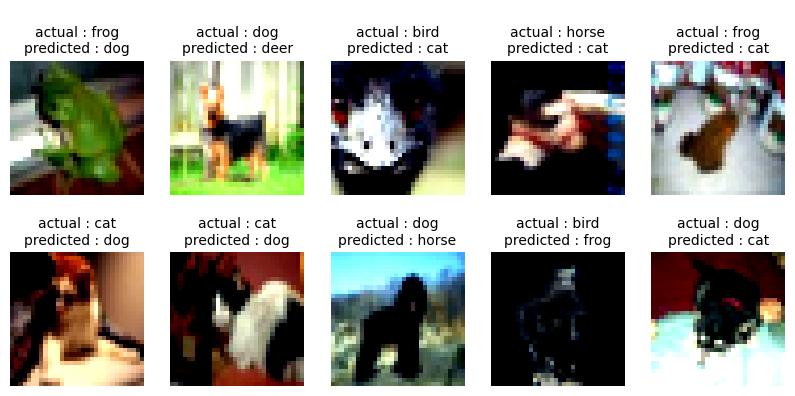

In [11]:
model_gap_mc = torch.load(f'./saved_models/{experiment_name_gap}.pt')
model_gap_mc.eval()
trigger_training_gap.wrong_predictions(model_gap_mc)


### Plots for Validation Loss and Accuracy

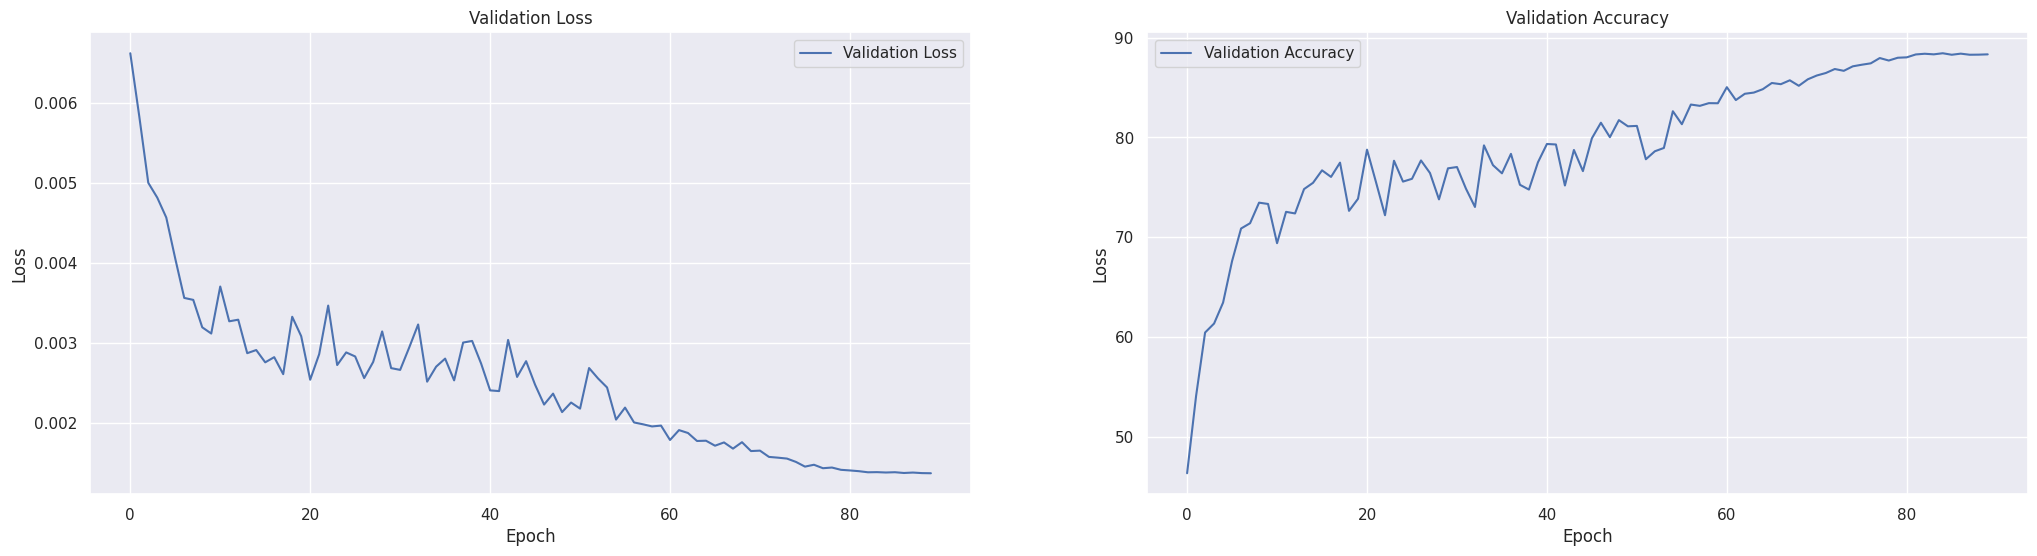

In [12]:
plot_metrics.plot_metrics(exp_metrics_gap[experiment_name_gap])

### Accuracy for each class

In [15]:
helper.class_level_accuracy(model_gap, cifar_dataset.test_loader, device, classes)

Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 81 %
Accuracy of   cat : 73 %
Accuracy of  deer : 87 %
Accuracy of   dog : 82 %
Accuracy of  frog : 92 %
Accuracy of horse : 91 %
Accuracy of  ship : 93 %
Accuracy of truck : 93 %


**model_fc: incorporates fully connected last layer**

In [ ]:
exp_metrics_fc = {}
config['model_params']['experiment_name'] = 'CiFar_Model_FC'
experiment_name_fc = config['model_params']['experiment_name']

config['model_params']['model_for'] = 'fc'
config['model_params']['model_name'] = 'CiFar_Model_FC'
config['model_params']['save_model'] = 'Y'
trigger_training_fc = TriggerEngine(config)

# trigger_training.
(exp_metrics_fc[experiment_name_fc]), model_fc = trigger_training_fc.run_experiment()
trigger_training_fc.save_experiment(model_fc, experiment_name_fc)


## Model summary

In [ ]:
trigger_training_fc.model_summary(model_fc, (3,32,32))

## Missclassification

In [ ]:
model_fc_mc = torch.load(f'./saved_models/{experiment_name_fc}.pt')
model_fc_mc.eval()
trigger_training_fc.wrong_predictions(model_fc_mc)


## Plots for Validation Loss and Accuracy

In [ ]:
plot_metrics.plot_metrics(exp_metrics_fc[experiment_name_fc])

## Accuracy for each class

In [ ]:
helper.class_level_accuracy(model_fc, cifar_dataset.test_loader, device, classes)